# Basic Qiskit Syntax

tutorial taken from: https://qiskit.org/textbook/ch-appendix/qiskit.html

In [2]:
import qiskit
from qiskit import QuantumCircuit
print("qiskit version: {}".format(qiskit.__version__))

qiskit version: 0.20.2


In [3]:
qc = QuantumCircuit() # empty circuit object: no qubits, no outputs

In [4]:
from qiskit import QuantumRegister

In [5]:
numBits = 2
regName = 'a' # optional
qr = QuantumRegister(size=numBits, name=regName)

In [6]:
try:
    qc.add_register(qr)
except Exception as e:
    print("{}: {}".format(type(e).__name__, e))
    
qc.qregs

[QuantumRegister(2, 'a')]

In [7]:
qc.draw() # By default, the quibots are in state |0>

a_0: 
     
a_1:

In [8]:
qc.h(qr[0]) # specify the qubits to be acted upon

In [9]:
#add a controlled-NOT gate to the circuit
qc.cx(control_qubit= qr[0], target_qubit=qr[1])

# draw it
qc.draw()

┌───┐     
a_0: ┤ H ├──■──
     └───┘┌─┴─┐
a_1: ─────┤ X ├
          └───┘

### Aer simulator
Use 'aer simulator' to see whaat is happening to the state vector of the two qubits.

In [10]:
from qiskit import Aer # Aer is the interface to the Qiskit Aer simulator
from qiskit import assemble
"""
In Qiskit Aer, the quantum circuit is executed by simulating the qubits.
To set up a job for a backend, we need to set up the corresponding backend object.

All the simulators are 'local' -> no need to sign up to IBMQ user agreement

To run the simulation we need to assemble the circuit into a `Qobj` which contains
the circuit as weel as other information about how to run the experiment.

"""
sv_sim = Aer.get_backend('aer_simulator')
qc.save_statevector()
qobj = assemble(qc)
job_handler = sv_sim.run(qobj) # ALl we need from the job handler is the result, specifically the statevector

In [11]:
ket = job_handler.result().get_statevector()
for amplitude in ket:
    print("{:.4f}".format(amplitude)) # that's the vecotr for a Bell state: (|00> + |11>)/sqrt(2)

0.7071+0.0000j
0.0000+0.0000j
0.0000+0.0000j
0.7071+0.0000j


<ipython-input-11-a3f9d888de08>:2: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for amplitude in ket:


#### Initialize a circuit with an arbitry pure state

In [12]:
new_qc = QuantumCircuit(qr)

new_qc.initialize(ket, qr)

### Classical registers and the Aer simulator

In the simulation we got a statevector, but that's **not** what we'd get from a real quantum computer: for that we need **measurements** and **registers**.

In [13]:
from qiskit import ClassicalRegister
nBits = 2
name = 'creg'
cr = ClassicalRegister(size=nBits, name=name)

qc.add_register(cr)


Now we can use the *measure()* method of the quantum circuit. This requires two arguments: 
1. the quibit being measured
2. the bit where the result is written

In [14]:
qBitToMeasure0, cbitToStoreResult0  = qr[0], cr[0]
qBitToMeasure1, cbitToStoreResult1  = qr[1], cr[1]

qc.measure(qBitToMeasure0, cbitToStoreResult0)
qc.measure(qBitToMeasure1, cbitToStoreResult1)

# draw it
qc.draw()

┌───┐      ░ ┌─┐   
   a_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   a_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
creg: 2/══════════════╩══╩═
                      0  1

In [15]:
memory = True # for compatible backends, we can get the ordered list of results
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(qc, shots=1024)
job_handler = aer_sim.run(qobj, memory=memory)
samples = job_handler.result().get_memory()
print(samples)

['00', '00', '00', '11', '00', '11', '11', '00', '00', '11', '00', '00', '11', '11', '00', '11', '00', '11', '00', '11', '00', '00', '11', '00', '11', '00', '00', '00', '11', '00', '00', '11', '00', '11', '00', '00', '00', '00', '11', '00', '11', '11', '11', '11', '11', '00', '00', '11', '00', '00', '11', '00', '00', '11', '00', '11', '00', '11', '11', '11', '11', '11', '00', '11', '11', '00', '00', '00', '11', '11', '11', '00', '11', '11', '00', '11', '00', '11', '00', '11', '11', '11', '11', '11', '00', '11', '11', '11', '11', '11', '00', '00', '11', '11', '00', '00', '11', '11', '11', '00', '11', '00', '00', '00', '11', '11', '00', '00', '00', '00', '00', '00', '11', '00', '00', '11', '00', '00', '00', '00', '11', '11', '00', '11', '11', '00', '00', '00', '00', '11', '00', '00', '11', '11', '11', '11', '00', '00', '00', '00', '00', '11', '11', '00', '00', '00', '00', '11', '00', '11', '11', '11', '00', '00', '11', '00', '00', '11', '11', '11', '00', '11', '00', '11', '00', '11', '11

The result is an histogram in the form of a Python dictionary. Use print to display this for us.

In [16]:
hist = job_handler.result().get_counts()
print(hist)

{'00': 512, '11': 512}


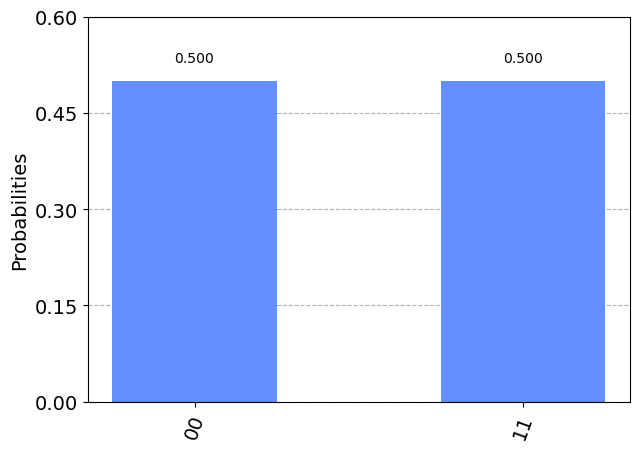

In [17]:
from qiskit.visualization import plot_histogram
plot_histogram(hist)

> **Note:** bits are labelled from right to left. So `cr[0]` is the one to the furthest right, and so on. As an example of this, here's an 8 qubit circuit with a **Pauli X** on only the qubit #7, which has its output stored to the bit numbered #7

In [19]:
# create 8 quantum registers
qr8 = QuantumRegister(size=8, name='qr8')
# ... and 8 classical registers
cr8 = ClassicalRegister(size=8, name='cr8')

# create a new circuit with the newly created registers
qc8 = QuantumCircuit(qr8, cr8)

qc8.x(qubit = qr8[7]) # Apply the pauli X gate
qc8.measure(qr8, cr8) # this is a way to do all the measurements at once

qobj = assemble(qc8, shots=1024)
hist = aer_sim.run(qobj).result().get_counts()
print(hist) # note the qr8[7] bit (the last one) is displayed in the first position once printed

{'10000000': 1024}


#### Simplified notation

When creating a QuantumCircuit, we either pass:
- the quantum/classical register instances
- or the number of qubits/classical bit to be included

In [20]:
nQubits = 3
qc = QuantumCircuit(nQubits) # by def. it creates a single QuantumRegister

# refer to the qubits by their index
qc.h(1) # apply the Hadamard gate to the first qubit
qc.draw()

q_0: ─────
     ┌───┐
q_1: ┤ H ├
     └───┘
q_2: ─────

In [21]:
qc = QuantumCircuit(2,1) # Creates a Quantum and a CLassical Register
qc.h(0)
qc.cx(control_qubit= 0, target_qubit = 1)
qc.measure(1,0)

qc.draw()


┌───┐        
q_0: ┤ H ├──■─────
     └───┘┌─┴─┐┌─┐
q_1: ─────┤ X ├┤M├
          └───┘└╥┘
c: 1/═══════════╩═
                0

#### Creating custom gates

It is possible to combine different circuits to make bigger and custom gates.

In [22]:
# Here is a circuit that implements a cx between qubits 0 and 2, using 1 qubit
# to mediate the process
sub_circuit = QuantumCircuit(3, name='toggle_cx')
sub_circuit.cx(0,1)
sub_circuit.cx(1,2)
sub_circuit.cx(0,1)
sub_circuit.cx(1,2)

sub_circuit.draw()

q_0: ──■─────────■───────
     ┌─┴─┐     ┌─┴─┐     
q_1: ┤ X ├──■──┤ X ├──■──
     └───┘┌─┴─┐└───┘┌─┴─┐
q_2: ─────┤ X ├─────┤ X ├
          └───┘     └───┘

turn this to a gate

In [23]:
toggle_cx = sub_circuit.to_instruction()

and then insert it into other circuits using any set of qubits we choose

In [27]:
qr = QuantumRegister(4)
new_qc = QuantumCircuit(qr)

# draw it before the addition of the toggle_cx gate
new_qc.draw()

# add the toggle_cx gate
new_qc.append(toggle_cx, [qr[1], qr[2], qr[3]])

# draw it after the addition of the toggle_cx gate
new_qc.draw()



q3_0: ──────────────
      ┌────────────┐
q3_1: ┤0           ├
      │            │
q3_2: ┤1 toggle_cx ├
      │            │
q3_3: ┤2           ├
      └────────────┘

#### Accessing on real quantum hardware

Backend objects can also be set up using the IBMQ package.
**nb:** the use of these requires to sign with an IBMQ account.

In [ ]:
#TODO
# continue with the tutorial